In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf

from sklearn.utils import shuffle, resample
from tqdm import tqdm

from keras.utils import load_img, img_to_array, to_categorical
from keras.models import model_from_json, Model
from keras.optimizers import SGD, RMSprop, Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

## REFUGE

In [ ]:
# Load the CSV file
df_train = pd.read_csv('path/to/REFUGE/train/output.csv')
dataset_path_train = 'path/to/REFUGE/train/Images'

df_val = pd.read_csv('path/to/REFUGE/val/output.csv')
dataset_path_val = 'path/to/REFUGE/val/Images'

# Define constants
IMAGE_SIZE = (256, 256)  # Example size, adjust to your models
NUM_CLASSES = 2  # Grading levels 0-5

In [ ]:
df_train['Label'].value_counts()

In [ ]:
df_val['Label'].value_counts()

In [ ]:
# ODOC
with open('models_segmentation/ODOC.json', 'r') as json_file:
    model_json = json_file.read()
model_OCOD = model_from_json(model_json)
model_OCOD.load_weights('models_segmentation/ODOC.weights.h5')
model_OCOD.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Load model

In [ ]:
with open('models_features/CNN_ODOC.json', 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights('models_features/CNN_ODOC.weights.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Load

In [ ]:
# Define function to preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img = img_to_array(img)
    img = img / 255.0
    return img

def generate_feature_maps(image_path):
    # Apply the specific preprocessing method for each model
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    mask = model_OCOD.predict(img, verbose=False)  # Predict mask    
    mask_discrete = np.zeros_like(mask)  # Initialize with zeros
    mask_discrete[(mask >= 0.25) & (mask < 0.75)] = 0.5  # Set to 0.5 where within range
    mask_discrete[mask >= 0.75] = 1
    # Combine masks into a single feature map
    combined = np.transpose(mask_discrete, (1, 2, 0, 3))
    combined = np.squeeze(combined)
    
    return combined

In [ ]:
# Prepare dataset
X = []
y = []

for index, row in tqdm(df_train.iterrows(), total=len(df_train), desc="Processing rows"):
    image_path = row['ImgName']
    label = row['Label']
    
    image_path = os.path.join(dataset_path_train, image_path)
    x = generate_feature_maps(image_path)
    X.append(x)
    y.append(label)
    
for index, row in tqdm(df_val.iterrows(), total=len(df_val), desc="Processing rows"):
    image_path = row['ImgName']
    label = row['Label']
    
    image_path = os.path.join(dataset_path_val, image_path)
    x = generate_feature_maps(image_path)
    X.append(x)
    y.append(label)
    
    
X_features = np.array(X)
y_labels = np.array(y)

X_features = np.array(X_features)  # Shape: (num_samples, H, W, 4)
y_labels = tf.keras.utils.to_categorical(y_labels, NUM_CLASSES)

In [ ]:
X_features.shape, y_labels.shape

In [ ]:
predictions = model.predict(X_features)
y_pred = np.argmax(predictions, axis=1)  # Multiclass output
y_true = np.argmax(y_labels, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
classification_rep = classification_report(y_true, y_pred, target_names=[f'Grade {i}' for i in range(2)])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("\nClassification Report:")
print(classification_rep)

# ORIGA

In [2]:
# Load the CSV file
df = pd.read_csv('path/to/ORIGA/OrigaList.csv')
dataset_path = 'path/to/ORIGA/Images'

# Define constants
IMAGE_SIZE = (256, 256)  # Example size, adjust to your models
NUM_CLASSES = 2  # Grading levels 0-5

In [3]:
df['Glaucoma'].value_counts()

Glaucoma
0    482
1    168
Name: count, dtype: int64

## Load

In [6]:
# Define function to preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img = img_to_array(img)
    img = img / 255.0
    return img

def generate_feature_maps(image_path):
    # Apply the specific preprocessing method for each model
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    mask = model_OCOD.predict(img, verbose=False)  # Predict mask    
    mask_discrete = np.zeros_like(mask)  # Initialize with zeros
    mask_discrete[(mask >= 0.25) & (mask < 0.75)] = 0.5  # Set to 0.5 where within range
    mask_discrete[mask >= 0.75] = 1
    # Combine masks into a single feature map
    combined = np.transpose(mask_discrete, (1, 2, 0, 3))
    combined = np.squeeze(combined)
    
    return combined

In [7]:
# Prepare dataset
X = []
y = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    image_path = row['Filename']
    label = row['Glaucoma']
    
    image_path = os.path.join(dataset_path, image_path)
    x = generate_feature_maps(image_path)
    X.append(x)
    y.append(label)

X_features = np.array(X)
y_labels = np.array(y)

X_features = np.array(X_features)  # Shape: (num_samples, H, W, 4)
y_labels = tf.keras.utils.to_categorical(y_labels, NUM_CLASSES)

Processing rows:   0%|          | 0/650 [00:00<?, ?it/s]2024-12-11 23:16:35.149412: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-12-11 23:16:35.207439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Processing rows: 100%|██████████| 650/650 [00:42<00:00, 15.34it/s]


In [8]:
X_features.shape, y_labels.shape

((650, 256, 256), (650, 2))

2024-12-11 23:17:17.749954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 42ms/step


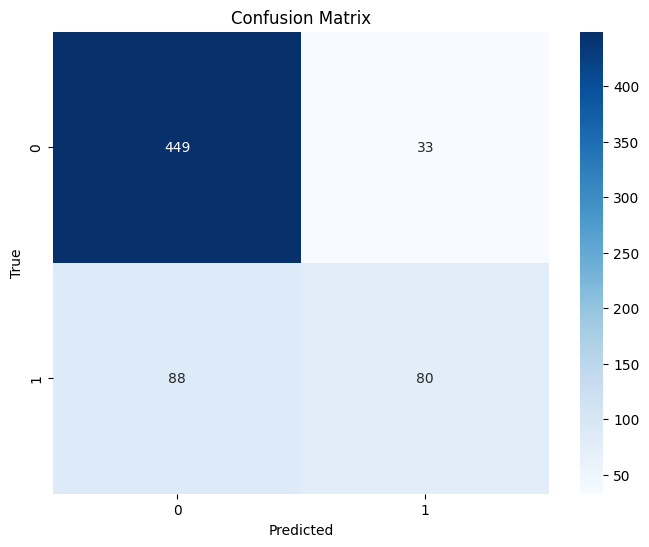

In [9]:
predictions = model.predict(X_features)
y_pred = np.argmax(predictions, axis=1)  # Multiclass output
y_true = np.argmax(y_labels, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [10]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
classification_rep = classification_report(y_true, y_pred, target_names=[f'Grade {i}' for i in range(2)])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.8138461538461539
Precision: 0.8030016745832239
Recall: 0.8138461538461539

Classification Report:
              precision    recall  f1-score   support

     Grade 0       0.84      0.93      0.88       482
     Grade 1       0.71      0.48      0.57       168

    accuracy                           0.81       650
   macro avg       0.77      0.70      0.73       650
weighted avg       0.80      0.81      0.80       650

